In [1]:
import math
import numpy as np
import random as rand
from numba import jit,int64,float64
import matplotlib.pyplot as plt
%matplotlib inline

#To increase cell width:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Color-blind friendly colors to plot:
# CB_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
# CB_colors.reverse()
CB_colors = ['#00429d', '#93003a']

In [2]:
#The spacetime parameters. Let the population distribution of gene expression level be g:
g_min = 0
g_max = 100
dg = 0.4
#Defining a g_ghost which contains two extra `ghost' points at the edges:
g_ghost = np.arange(g_min-dg,g_max+2*dg,dg)
g = np.array(g_ghost[1:-1])
#The peak of the unregulated distribution:
g_peak = 0.5*(g_min+g_max)

#Parameters:
K = 1
delta = 1000
alpha = 0.5

#Constant environment, T fixed:
dt = np.minimum(0.00005/K,0.01/delta)
T = 10
# #If tau is too large, we don't change:
# num_cycles = 8
# T = num_cycles*tau
TimeRange = np.arange(0,T,dt)
print(len(TimeRange))

#Tolerance to calculate entropy:
eps = 1e-100

#The noise variance D:
D = alpha*K*g_peak

#Checks:
print(f"K = {K}; 0.5*dg/dt = {0.5*dg/dt}")
print(f"D = {D}; 0.5*dg**2/dt = {0.5*dg**2/dt}")

#Stability check:
flag_stability=0
if (K>=int(0.5*dg/dt) or D>=int(0.5*dg**2/dt)):
    flag_stability=1
    print("Warning! FTCS unstable.")

1000000
K = 1; 0.5*dg/dt = 20000.0
D = 25.0; 0.5*dg**2/dt = 8000.000000000001


In [3]:
#First derivative, central difference method (used in the potential term K*d/dg (g*P)):
@jit("float64[:](float64[:],float64)",nopython=True)
def derv1(func,dx):
    func_left = func[0:-2]
    func_right = func[2:]
    #Below we calculate the first derivative using the central difference method:
    derivative = (func_right - func_left)/(2*dx)
    return derivative

#Second derivative using central difference, used in the diffusion term (D*d2/dg2 (P)):
@jit("float64[:](float64[:],float64)",nopython=True)
def derv2(func,dx):
    func_left = func[0:-2]
    func_right = func[2:]
    func_center = func[1:-1]
    #Below we calculate the second derivative, again using central difference method:
    derivative2 = (func_right + func_left - 2*func_center)/(dx**2)
    return derivative2

#Defining a Gaussian pdf - we'll need it for P(g,t=0), the initial distribution:
@jit(nopython=True)
def Gaussian(x,mu,sigma):
    dist = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((x-mu)/sigma)**2)
    return dist

#The function to calculate <f> dynamically, i.e. int_g f(g,s) P(g,t):
@jit(nopython=True)
def mean_wrt_P(func,P,g):
    integrand = func*P
    integral = np.trapz(integrand,g)
    return integral

#Defining the fitness function:
# @jit(["float64[:](float64[:],float64,float64)","float64(float64,float64,float64)"],nopython=True)
def fitness(g,s,delta):
    fit = delta*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max)))/g_max
    return fit

@jit(nopython=True)
def discrete_entropy(p_dist):
    p_dist = p_dist[np.where(np.clip(p_dist,eps,None)>eps)]
    return np.sum(p_dist*np.log2(1/p_dist))

@jit(nopython=True)
def cont_entropy(p_dist):
    p_dist = p_dist[np.where(np.clip(p_dist,eps,None)>eps)]
    return np.trapz(p_dist*np.log2(1/p_dist),dx=dg)

@jit(nopython=True)
def selection_const_noise(p0_unreg,p0_reg,s,K,alpha,delta,T,dt):
    #First, time:
#     dt = 0.0001/K
    TimeRange = np.arange(0,T,dt)
    
    #Then, define the fitness function:
    fit = delta*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max)))/g_max
    g_reg = g[np.argmax(fit)]

    #Now let's compare the effects of regulation vs selection:
    p_unreg = p0_unreg
    p_reg = p0_reg
    flag_unreg = 0
    flag_reg = 0
    
#     #Storing dynamic fitness:
#     dyn_fit_unreg = np.zeros_like

    #Now evolve it:
    for t in range(len(TimeRange)):
        #Constant noise:
        D_unreg = alpha*K*g_peak
        D_reg = alpha*K*g_peak

    #     #Checks:
    #     if (t%10==0):
    #         print(f"\nt={t}; g_mean_unreg={round(g_mean_unreg,2)}; D_unreg={round(D_unreg,2)}; max allowed={0.5*dg**2/dt}")
    #         print(f"t={t}; g_mean_reg={round(g_mean_reg,2)}; D_reg={round(D_reg,2)}; max allowed={0.5*dg**2/dt}")        

        #Now creating the expanded p's, with ghost points. The bulk points are the same in each. Unregulated:
        p_unreg_ghost = np.zeros(len(p_unreg)+2)
        p_unreg_ghost[1:-1] = p_unreg
        #Regulated:
        p_reg_ghost = np.zeros(len(p_reg)+2)
        p_reg_ghost[1:-1] = p_reg

        #Setting the value of the ghost points. This represents the zero flux boundary conditions. Unregulated:
        p_unreg_ghost[0] = p_unreg[1] + 2*dg*(K/D_unreg)*(g[0]-g_peak)*p_unreg[0]
        p_unreg_ghost[-1] = p_unreg[-2] + 2*dg*(K/D_unreg)*(g_peak-g[-1])*p_unreg[-1]
        #Regulated:
        p_reg_ghost[0] = p_reg[1] + 2*dg*(K/D_reg)*(g[0]-g_reg)*p_reg[0]
        p_reg_ghost[-1] = p_reg[-2] + 2*dg*(K/D_reg)*(g_reg-g[-1])*p_reg[-1]    

        #Now to solve the equation. Unregulated first:
        p_unreg += dt*((fit - mean_wrt_P(fit,p_unreg,g))*p_unreg \
                    + K*derv1((g_ghost-g_peak)*p_unreg_ghost,dg) + D_unreg*derv2(p_unreg_ghost,dg))
        p_reg += dt*((fit - mean_wrt_P(fit,p_reg,g))*p_reg \
                    + K*derv1((g_ghost-g_reg)*p_reg_ghost,dg) + D_reg*derv2(p_reg_ghost,dg))

#         #Finally, for the edge cases, we normalize:
#         if (flag_unreg==1 or delta>=1):
#             p_unreg = p_unreg/np.trapz(p_unreg,dx=dg)
#         if (flag_reg==1 or delta>=1):
#             p_reg = p_reg/np.trapz(p_reg,dx=dg)
            
    return p_unreg,p_reg

@jit(nopython=True)
def selection_dyn_const_noise(p0_unreg,p0_reg,sug_dyn,K,alpha,delta,T,dt):
    #First, time:
    TimeRange = np.arange(0,T,dt)    
    
    #Then, define the fitness function:
    s = sug_dyn[0]
    fit = delta*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max)))/g_max
    g_reg = g[np.argmax(fit)]

    #Now let's compare the effects of regulation vs selection:
    p_unreg = p0_unreg
    p_reg = p0_reg
    flag_unreg = 0
    flag_reg = 0
    
    #Storing dynamic fitness:
    dyn_fit_unreg, dyn_norm_fit_unreg, dyn_fit_reg, dyn_norm_fit_reg = np.zeros_like(TimeRange), np.zeros_like(TimeRange), np.zeros_like(TimeRange), np.zeros_like(TimeRange)
    #Dynamic distributions:
    dyn_p_unreg, dyn_p_reg = np.zeros((len(TimeRange),len(g))), np.zeros((len(TimeRange),len(g)))
    dyn_p_unreg[0,:], dyn_p_reg[0,:] = p_unreg, p_reg    

    #Now evolve it:
    for t in range(len(TimeRange)):
        #First setting the dynamic sugar and g_reg:
        s = sug_dyn[t]
        fit = delta*(g*s/(400+s) - (2/17)*g/(1-g/(1.8*g_max)))/g_max
        g_reg = g[np.argmax(fit)]
            
        #Constant noise:
        D_unreg = alpha*K*g_peak
        D_reg = alpha*K*g_peak

    #     #Checks:
    #     if (t%10==0):
    #         print(f"\nt={t}; g_mean_unreg={round(g_mean_unreg,2)}; D_unreg={round(D_unreg,2)}; max allowed={0.5*dg**2/dt}")
    #         print(f"t={t}; g_mean_reg={round(g_mean_reg,2)}; D_reg={round(D_reg,2)}; max allowed={0.5*dg**2/dt}")        

        #Now creating the expanded p's, with ghost points. The bulk points are the same in each. Unregulated:
        p_unreg_ghost = np.zeros(len(p_unreg)+2)
        p_unreg_ghost[1:-1] = p_unreg
        #Regulated:
        p_reg_ghost = np.zeros(len(p_reg)+2)
        p_reg_ghost[1:-1] = p_reg

        #Setting the value of the ghost points. This represents the zero flux boundary conditions. Unregulated:
        p_unreg_ghost[0] = p_unreg[1] + 2*dg*(K/D_unreg)*(g[0]-g_peak)*p_unreg[0]
        p_unreg_ghost[-1] = p_unreg[-2] + 2*dg*(K/D_unreg)*(g_peak-g[-1])*p_unreg[-1]
        #Regulated:
        p_reg_ghost[0] = p_reg[1] + 2*dg*(K/D_reg)*(g[0]-g_reg)*p_reg[0]
        p_reg_ghost[-1] = p_reg[-2] + 2*dg*(K/D_reg)*(g_reg-g[-1])*p_reg[-1]    

        #Now to solve the equation. Unregulated first:
        p_unreg += dt*((fit - mean_wrt_P(fit,p_unreg,g))*p_unreg \
                    + K*derv1((g_ghost-g_peak)*p_unreg_ghost,dg) + D_unreg*derv2(p_unreg_ghost,dg))
        p_reg += dt*((fit - mean_wrt_P(fit,p_reg,g))*p_reg \
                    + K*derv1((g_ghost-g_reg)*p_reg_ghost,dg) + D_reg*derv2(p_reg_ghost,dg))

#         #Finally, for the edge cases, we normalize:
#         if (flag_unreg==1 or delta>=1): #Because apparently this blows up temporarily when delta>1
#             p_unreg = p_unreg/np.trapz(p_unreg,dx=dg)
#         if (flag_reg==1 or delta>=1):
#             p_reg = p_reg/np.trapz(p_reg,dx=dg)
            
        #Storing the dynamic distributions:
        dyn_p_unreg[t,:], dyn_p_reg[t,:] = p_unreg, p_reg
            
        #Now calculating the dynamic fitnesses, absolute:
        dyn_fit_unreg[t] = mean_wrt_P(fit,p_unreg,g)
        dyn_fit_reg[t] = mean_wrt_P(fit,p_reg,g)
        #Normalized:
        dyn_norm_fit_unreg[t] = (dyn_fit_unreg[t] - np.min(fit))/(np.max(fit) - np.min(fit))
        dyn_norm_fit_reg[t] = (dyn_fit_reg[t] - np.min(fit))/(np.max(fit) - np.min(fit))
            
    return dyn_p_unreg, dyn_p_reg, dyn_fit_unreg, dyn_norm_fit_unreg, dyn_fit_reg, dyn_norm_fit_reg

In [4]:
#Let's try to find average colony fitness over many sugars:
# sugars_arr = np.logspace(np.log10(60),np.log10(430),num=3)
sugars_arr = np.array([68,85,120,210,430]) #63,80,120,210,430
g_opt_arr = np.zeros_like(sugars_arr)

for sug_idx in range(len(sugars_arr)):
    g_opt_arr[sug_idx] = g[np.argmax(fitness(g,sugars_arr[sug_idx],delta))]
    
#Probability of sugars:
p_sug = np.ones_like(sugars_arr)
p_sug = p_sug/np.sum(p_sug)

#The fitness arrays over multiple environments:
dyn_fit_unreg_arr = np.zeros((len(sugars_arr),len(TimeRange)))
dyn_fit_reg_arr = np.zeros((len(sugars_arr),len(TimeRange)))\

#Parameters:
K = 1
delta = 100
alpha = 0.5

#Constant environment, T fixed:
dt = np.minimum(0.00005/K,0.01/delta)
T = 5
TimeRange = np.arange(0,T,dt)

#The noise variance D:
D = alpha*K*g_peak

#Checks:
print(f"dt*delta = {dt*delta}")
print(f"dt*K = {dt*K}")
print(f"No. of timepoints: {len(TimeRange)}")
print(f"K = {K}; 0.5*dg/dt = {0.5*dg/dt}")
print(f"D = {D}; 0.5*dg**2/dt = {0.5*dg**2/dt}")
print(f"g optima: {g_opt_arr}")

#Stability check:
flag_stability=0
if (K>=int(0.5*dg/dt) or D>=int(0.5*dg**2/dt)):
    flag_stability=1
    print("Warning! FTCS unstable.")


#Initials:
p0_unreg = Gaussian(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1))
p0_unreg = p0_unreg/np.trapz(p0_unreg,dx=dg)
p0_reg = Gaussian(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1))
p0_reg = p0_reg/np.trapz(p0_reg,dx=dg)

dt*delta = 0.005
dt*K = 5e-05
No. of timepoints: 100000
K = 1; 0.5*dg/dt = 4000.0
D = 25.0; 0.5*dg**2/dt = 1600.0000000000002
g optima: [18 32 51 74 94]


In [5]:
np.linspace(start=0.5,stop=13.5,num=9)

array([ 0.5  ,  2.125,  3.75 ,  5.375,  7.   ,  8.625, 10.25 , 11.875,
       13.5  ])

In [34]:
#Choosing deltas and alphas:
deltas_arr = np.array([10**i for i in range(3,5)])
# alphas_arr = np.array([0.5,1.5,4.5,13.5])
alphas_arr = np.linspace(start=0.5,stop=13.5,num=9)

#To show the distinguishability, let's initialize some populations and evolve them:
p_unreg_sug = np.zeros((len(deltas_arr),len(alphas_arr),len(sugars_arr),len(g)))
p_reg_sug = np.zeros((len(deltas_arr),len(alphas_arr),len(sugars_arr),len(g)))
fit_unreg_sug = np.zeros((len(deltas_arr),len(alphas_arr),len(sugars_arr)))
fit_reg_sug = np.zeros((len(deltas_arr),len(alphas_arr),len(sugars_arr)))
fit_norm_unreg = np.zeros((len(deltas_arr),len(alphas_arr)))
fit_norm_reg = np.zeros((len(deltas_arr),len(alphas_arr)))

#First looping over deltas, then alphas:
for delta_idx in range(len(deltas_arr)):
    delta = deltas_arr[delta_idx]
    for alpha_idx in range(len(alphas_arr)):
        alpha = alphas_arr[alpha_idx]
        dt = np.minimum(0.00005/K,0.01/delta)
        T = 10
        #To calculate normalized fitness:
        fit_unreg_sum = 0
        fit_reg_sum = 0
        #For each sugar, we find the distributions given the parameters:
        for sug_idx in range(len(sugars_arr)):
            #Initials:
            p0_unreg = Gaussian(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1))
            p0_unreg = p0_unreg/np.trapz(p0_unreg,dx=dg)
            p0_reg = Gaussian(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1))
            p0_reg = p0_reg/np.trapz(p0_reg,dx=dg)
            #Sugar and reg peak:
            sug = sugars_arr[sug_idx]
            g_reg = g[np.argmax(fitness(g,sug,delta))]
            #Evolution:
            p_unreg_sug[delta_idx,alpha_idx,sug_idx],p_reg_sug[delta_idx,alpha_idx,sug_idx] = selection_const_noise(p0_unreg,p0_reg,sug,K,alpha,delta,T,dt)
            fit_unreg_sug[delta_idx,alpha_idx,sug_idx] = mean_wrt_P(fitness(g,sug,delta),p_unreg_sug[delta_idx,alpha_idx,sug_idx],g)
            fit_reg_sug[delta_idx,alpha_idx,sug_idx] = mean_wrt_P(fitness(g,sug,delta),p_reg_sug[delta_idx,alpha_idx,sug_idx],g)
            #Normalized fitness:
            fit_unreg_sum += (fit_unreg_sug[delta_idx,alpha_idx,sug_idx] - np.min(fitness(g,sug,delta)))/(np.max(fitness(g,sug,delta)) - np.min(fitness(g,sug,delta)))
            fit_reg_sum += (fit_reg_sug[delta_idx,alpha_idx,sug_idx] - np.min(fitness(g,sug,delta)))/(np.max(fitness(g,sug,delta)) - np.min(fitness(g,sug,delta)))        
        #The normalized fitness:
        fit_norm_unreg[delta_idx,alpha_idx] = fit_unreg_sum/len(sugars_arr)
        fit_norm_reg[delta_idx,alpha_idx] = fit_reg_sum/len(sugars_arr)

In [35]:
np.max(np.trapz(p_unreg_sug,axis=3,dx=dg))

1.0097162106470934

In [39]:
np.shape(fit_norm_reg)

(2, 9)

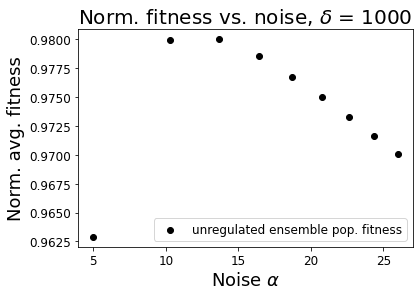

In [78]:
fig,ax = plt.subplots(1,1)
# ax.set_box_aspect(1)
# ax.set_ylim([0.99*np.min(fit_norm_unreg), 1.01*np.max(fit_norm_unreg)])
ax.scatter(np.sqrt(alphas_arr*g_peak),fit_norm_unreg[0],color='k',label='unregulated ensemble pop. fitness')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel(r'Noise $\alpha$',fontsize=18)
ax.set_ylabel('Norm. avg. fitness',fontsize=18)
ax.legend(loc="lower right",fontsize=12)
ax.set_title(fr'Norm. fitness vs. noise, $\delta$ = {deltas_arr[0]}', fontsize=20)
fig.savefig("20221212_POPULATIONS_optimal noise_delta1000.pdf",format="pdf",dpi=400)

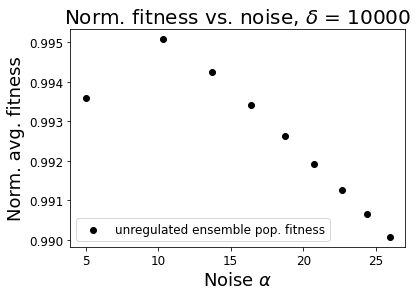

In [79]:
fig,ax = plt.subplots(1,1)
# ax.set_box_aspect(1)
# ax.set_ylim([0.95*np.min(fit_norm_unreg), 1.05*np.max(fit_norm_unreg)])
ax.scatter(np.sqrt(alphas_arr*g_peak),fit_norm_unreg[1],color='k',label='unregulated ensemble pop. fitness')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel(r'Noise $\alpha$',fontsize=18)
ax.set_ylabel('Norm. avg. fitness',fontsize=18)
ax.legend(loc="lower left",fontsize=12)
ax.set_title(fr'Norm. fitness vs. noise, $\delta$ = {deltas_arr[1]}', fontsize=20)
fig.savefig("20221212_POPULATIONS_optimal noise_delta10000.pdf",format="pdf",dpi=400)

In [40]:
#Loading to and saving from text:
# np.savetxt("static_env_unreg_dist.txt",p_unreg_sug.flatten())
# np.savetxt("static_env_reg_dist.txt",p_reg_sug.flatten())
np.savetxt("static_env_unreg_dist_optimal_noise.txt",p_unreg_sug.flatten())
np.savetxt("static_env_reg_dist_optimal_noise.txt",p_reg_sug.flatten())
# p_unreg_sug = np.loadtxt("static_env_unreg_dist.txt").reshape(len(deltas_arr),len(alphas_arr),len(sugars_arr),len(g))
# p_reg_sug = np.loadtxt("static_env_reg_dist.txt").reshape(len(deltas_arr),len(alphas_arr),len(sugars_arr),len(g))

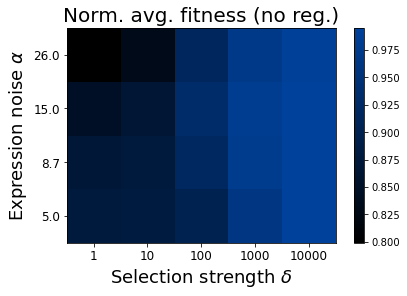

In [398]:
from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
#b81600
N = 256
no_reg = np.ones((N, 4))
no_reg[:, 0] = np.linspace(0, 0/256, N) # R = 55
no_reg[:, 1] = np.linspace(0, 66/256, N) # G = 126
no_reg[:, 2] = np.linspace(0, 157/256, N)  # B = 184
no_reg_cmp = ListedColormap(no_reg)
#3171c5
with_reg = np.ones((N, 4))
with_reg[:, 0] = np.linspace(0, 147/256, N) # R = 255
with_reg[:, 1] = np.linspace(0, 0/256, N) # G = 127
with_reg[:, 2] = np.linspace(0, 58/256, N)  # B = 0
with_reg_cmp = ListedColormap(with_reg)

# plt.imshow(fit_norm_unreg.T,cmap=no_reg_cmp,origin="lower")
fig,ax = plt.subplots(1,1,constrained_layout='true')
pic=ax.imshow(fit_norm_unreg.T,cmap=no_reg_cmp,origin='lower')
cbar = plt.colorbar(pic,shrink=1.0)
ax.set_xticks(ticks=range(5),labels=np.around(deltas_arr,decimals=2))
ax.set_yticks(ticks=range(4),labels=np.around(np.sqrt(alphas_arr*g_peak),decimals=1))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_ylabel(r'Expression noise $\alpha$',fontsize=18)
ax.set_xlabel(r'Selection strength $\delta$',fontsize=18)
ax.set_title(r'Norm. avg. fitness (no reg.)',fontsize=20)
fig.savefig(f"20221211_POPULATIONS_norm_fit_unreg_vs_delta&alpha.pdf",format="pdf",dpi=400,bbox_inches="tight")

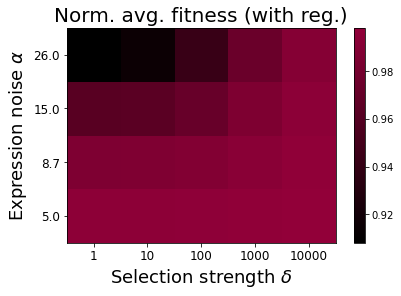

In [399]:
# plt.imshow(fit_norm_reg.T,cmap=with_reg_cmp,origin="lower")
fig,ax = plt.subplots(1,1,constrained_layout='true')
pic=ax.imshow(fit_norm_reg.T,cmap=with_reg_cmp,origin='lower')
cbar = plt.colorbar(pic,shrink=1.0)
ax.set_xticks(ticks=range(5),labels=np.around(deltas_arr,decimals=2))
ax.set_yticks(ticks=range(4),labels=np.around(np.sqrt(alphas_arr*g_peak),decimals=1))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_ylabel(r'Expression noise $\alpha$',fontsize=18)
ax.set_xlabel(r'Selection strength $\delta$',fontsize=18)
ax.set_title(r'Norm. avg. fitness (with reg.)',fontsize=20)
fig.savefig(f"20221211_POPULATIONS_norm_fit_reg_vs_delta&alpha.pdf",format="pdf",dpi=400,bbox_inches="tight")

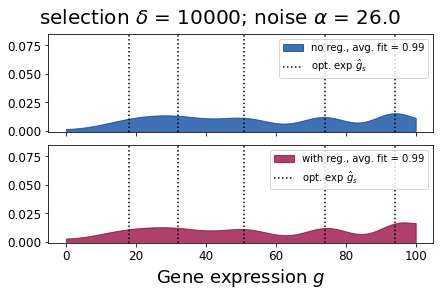

In [32]:
#Plotting the final unreg and reg distributions:
fig,ax = plt.subplots(2,1,constrained_layout=True,sharex=True)

#Choosing which delta and alpha to represent:
delta_idx = 4
alpha_idx = 3

# ax[0].set_box_aspect(1)
ax[0].fill_between(g,np.mean(p_unreg_sug[delta_idx,alpha_idx],axis=0),alpha=0.75,label=f"no reg., avg. fit = {np.round(fit_norm_unreg[delta_idx,alpha_idx],2)}",color=CB_colors[0])
ax[0].axvline(x=g_opt_arr[0],color='k',ls=':',label=r"opt. exp $\hat{g}_s$")
for g_opt_idx in range(1,len(g_opt_arr)):
    ax[0].axvline(x=g_opt_arr[g_opt_idx],color='k',ls=':')
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].tick_params(axis='both', which='minor', labelsize=10)
ax[0].set_ylim(top=0.085)
ax[0].legend(loc="upper right")
    
ax[1].fill_between(g,np.mean(p_reg_sug[delta_idx,alpha_idx],axis=0),alpha=0.75,label=f"with reg., avg. fit = {np.round(fit_norm_reg[delta_idx,alpha_idx],2)}",color=CB_colors[1])
ax[1].axvline(x=g_opt_arr[0],color='k',ls=':',label=r"opt. exp $\hat{g}_s$")
for g_opt_idx in range(1,len(g_opt_arr)):
    ax[1].axvline(x=g_opt_arr[g_opt_idx],color='k',ls=':')
ax[1].set_xlabel("Gene expression $g$",fontsize=18)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='minor', labelsize=10)
ax[1].set_ylim(top=0.085)
ax[1].legend(loc="upper right")

# fig.supylabel("Distribution",fontsize=18)
# fig.text(-0.15,0.25,"Ensemble distribution",fontsize=18,rotation=90,transform=ax[1].transAxes)

fig.suptitle(fr"selection $\delta$ = {deltas_arr[delta_idx]}; noise $\alpha$ = {np.round(np.sqrt(alphas_arr[alpha_idx]*g_peak),decimals=1)}",fontsize=20)

fig.savefig(f"20221212_POPULATIONS_static_env_delta={deltas_arr[delta_idx]},alpha={alphas_arr[alpha_idx]}.pdf",format="pdf",dpi=600)

# ax.axvline(g_reg,color='k',ls='--',label=r'opt. expression $\hat{g}_s$')
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=10)
# ax.set_xlabel(r'Gene expression $g$',fontsize=18)
# ax.set_ylabel('Distribution',fontsize=18)
# ax.set_title('Final distributions of $g$', fontsize=20)
# ax.legend(loc="upper left")

Text(0.5, 0.98, 'selection $\\delta$ = 10000; noise $\\alpha$ = 1')

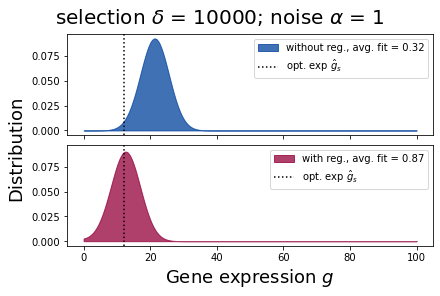

In [152]:
#Plotting the final unreg and reg distributions:
fig,ax = plt.subplots(2,1,constrained_layout=True,sharex=True,sharey=True)
# ax[0].set_box_aspect(1)
ax[0].fill_between(g,np.mean(p_unreg_sug,axis=0),alpha=0.75,label=f"without reg., avg. fit = {np.round(np.mean(fit_unreg_sug)/np.max(fitness(g,63,delta)),2)}",color=CB_colors[0],rasterized=True)
ax[0].axvline(x=g_opt_arr[0],color='k',ls=':',label=r"opt. exp $\hat{g}_s$")
for g_opt_idx in range(1,len(g_opt_arr)):
    ax[0].axvline(x=g_opt_arr[g_opt_idx],color='k',ls=':')
ax[0].legend(loc="best")
    
ax[1].fill_between(g,np.mean(p_reg_sug,axis=0),alpha=0.75,label=f"with reg., avg. fit = {np.round(np.mean(fit_reg_sug)/np.max(fitness(g,63,delta)),2)}",color=CB_colors[1],rasterized=True)
ax[1].axvline(x=g_opt_arr[0],color='k',ls=':',label=r"opt. exp $\hat{g}_s$")
for g_opt_idx in range(1,len(g_opt_arr)):
    ax[1].axvline(x=g_opt_arr[g_opt_idx],color='k',ls=':')
ax[1].set_xlabel("Gene expression $g$",fontsize=18)
ax[1].legend(loc="best")

fig.supylabel("Distribution",fontsize=18)
# fig.text(-0.15,0.25,"Ensemble distribution",fontsize=18,rotation=90,transform=ax[1].transAxes)

fig.suptitle(fr"selection $\delta$ = {delta}; noise $\alpha$ = {alpha}",fontsize=20)

# fig.savefig(f"20221202_POPULATIONS_ensemble dist_over_multiple_env_K,delta,alpha={K,delta,alpha}.pdf",format="pdf",dpi=400)

# ax.axvline(g_reg,color='k',ls='--',label=r'opt. expression $\hat{g}_s$')
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=10)
# ax.set_xlabel(r'Gene expression $g$',fontsize=18)
# ax.set_ylabel('Distribution',fontsize=18)
# ax.set_title('Final distributions of $g$', fontsize=20)
# ax.legend(loc="upper left")

In [91]:
# #Setting up static sugar environments:
# sug = 210
# sug_dyn = np.ones_like(TimeRange)*sug
# g_opt_dyn = np.ones_like(TimeRange)*g[np.argmax(fitness(g,sug,alpha))]

# #Let's see what's the effect of regulation when sugar changes:
# #The starting distributions:
# g_reg = g[np.argmax(fitness(g,sug_dyn[0],delta))]
# print(f"g_reg={round(g_reg,2)}")

# #Generating the initial distributions:
# g_peak = 0.5*(g_min+g_max)
# #We don't want a standard deviation of 0, so even if the g_reg is 0, we set the s.d. of p0_reg to 1:
# p0_unreg = Gaussian(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1))
# p0_unreg = p0_unreg/np.trapz(p0_unreg,dx=dg)
# # p0_reg = Gaussian(g,g_reg,np.maximum(np.sqrt(alpha*g_peak),1))
# #Starting with p0_reg same as unreg, but cells can sense:
# p0_reg = p0_unreg
# p0_reg = p0_reg/np.trapz(p0_reg,dx=dg)

In [92]:
# #Now, we evolve these in static sugar conditions:
# dyn_p_unreg, dyn_p_reg, dyn_fit_unreg, dyn_norm_fit_unreg, dyn_fit_reg, dyn_norm_fit_reg = selection_dyn_const_noise(p0_unreg,p0_reg,sug_dyn,K,alpha,delta,T,dt)

In [93]:
# np.max(np.trapz(dyn_p_unreg,dx=dg,axis=1))

In [94]:
# #To check if the distributions stay normalized:
# # np.min(np.trapz(dyn_p_unreg,dx=dg,axis=1))
# # np.max(np.trapz(dyn_p_reg,dx=dg,axis=1))

# #Plotting the final unreg and reg distributions:
# fig,ax = plt.subplots(1,1,constrained_layout=True)
# # ax.set_box_aspect(1)
# ax.fill_between(g,dyn_p_unreg[-1],alpha=0.75,label="without reg.",color=CB_colors[0])
# ax.fill_between(g,dyn_p_reg[-1],alpha=0.75,label="with reg.",color=CB_colors[1])
# ax.axvline(g_reg,color='k',ls='--',label=r'opt. expression $\hat{g}_s$')
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=10)
# ax.set_xlabel(r'Gene expression $g$',fontsize=18)
# ax.set_ylabel('Distribution',fontsize=18)
# ax.set_title('Final distributions of $g$', fontsize=20)
# ax.legend(loc="upper left")
# fig.savefig("320221211_POPULATIONS_final_dists_in_static_environment.pdf",format="pdf",dpi=400)

In [95]:
# #plotting the distributions:
# from matplotlib import cm 
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# #b81600
# N = 256
# no_reg = np.ones((N, 4))
# no_reg[:, 0] = np.linspace(0, 0/256, N) # R = 55
# no_reg[:, 1] = np.linspace(0, 66/256, N) # G = 126
# no_reg[:, 2] = np.linspace(0, 157/256, N)  # B = 184
# no_reg_cmp = ListedColormap(no_reg)
# #3171c5
# with_reg = np.ones((N, 4))
# with_reg[:, 0] = np.linspace(0, 147/256, N) # R = 255
# with_reg[:, 1] = np.linspace(0, 0/256, N) # G = 127
# with_reg[:, 2] = np.linspace(0, 58/256, N)  # B = 0
# with_reg_cmp = ListedColormap(with_reg)


# fig,ax = plt.subplots(1,1,constrained_layout='true')
# pic=ax.imshow(dyn_p_unreg.T,cmap=no_reg_cmp,origin='lower',aspect='auto',rasterized=True)
# cbar = plt.colorbar(pic,shrink=1.0)

# xticks = ax.get_xticks()
# yticks = ax.get_yticks()
# ax.set_xticks(ticks = xticks[1:-1],labels=np.around(xticks[1:-1]*dt,2))
# ax.set_yticks(ticks = yticks[1:-1],labels=np.around(yticks[1:-1]*dg,2))
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=10)
# ax.plot(g_opt_dyn/dg,'w--',label=r'opt. exp. $\hat{g}_s$')
# # ax.set_xlabel(r'Time $t$',fontsize=18)
# ax.set_ylabel(r'$g$ dist. (no reg.)',fontsize=18)
# ax.set_title(r'Distribution vs. time',fontsize=20)
# ax.legend(loc='best')
# fig.savefig("20221211_POPULATIONS_dyn_unreg.pdf",format="pdf",dpi=400)

In [96]:
# fig,ax = plt.subplots(1,1,constrained_layout='true')
# pic=ax.imshow(dyn_p_reg.T,cmap=with_reg_cmp,origin='lower',aspect='auto',rasterized=True)
# cbar = plt.colorbar(pic,shrink=1.0)

# xticks = ax.get_xticks()
# yticks = ax.get_yticks()
# ax.set_xticks(ticks = xticks[1:-1],labels=np.around(xticks[1:-1]*dt,2))
# ax.set_yticks(ticks = yticks[1:-1],labels=np.around(yticks[1:-1]*dg,2))
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=10)
# ax.set_xlabel(r'Time $t$ (arb. units)',fontsize=18)
# ax.set_ylabel(r'$g$ dist. (with reg.)',fontsize=18)
# ax.plot(g_opt_dyn/dg,'w--',label=r'opt. exp. $\hat{g}_s$')
# ax.legend(loc='best')
# fig.savefig("20221211_POPULATIONS_dyn_reg.pdf",format="pdf",dpi=400)
# # ax.set_title(r'Distribution vs. time',fontsize=20)